In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import math
import keyboard
from IPython.display import clear_output

import multiprocess as mp
from tqdm import tqdm

In [2]:
k=0.2/10*np.log(10)

NameError: name 'np' is not defined

In [11]:
# Z_n is the mean number of timeslots until all segments are generated 
def Z(p,N):
    sol_ = 0
    for j in range(1,N+1):
        term = math.comb(N,j) * (-1)**(j+1) / (1 - (1-p)**j)
        sol_ += term
    return sol_

def exp_subl(L,N):
    return Z(np.exp(-k*L/N),N)

## Heatmap generation

In [12]:
def prob_all_SaE(N,p,q,max_iter):
    shortest_sl = [(i,i+1) for i in range(N)]
    truth_vals = {(i,i+1):False for i in range(N)}
    truth_vals[(0,N)] = False
    counter = 0

    while True:
        counter += 1

        existing_links = np.sort([link for link in truth_vals if truth_vals[link]])
        for link in shortest_sl:
            big_link_exists = False
            if not truth_vals[link]:
                for big_link in existing_links:
                    if big_link[0]<=link[0] and link[-1]<=big_link[-1]:
                        big_link_exists = True
                        break
                if big_link_exists:
                    continue   
                
                if random.random() < p:
                    truth_vals[link] = True
        
        existing_links = np.sort([link for link in truth_vals if truth_vals[link]])

        temp_rep = 0
        all_linked = False
        while temp_rep != N:
            valid_links = [link for link in existing_links if link[0]==temp_rep]
            if len(valid_links) > 0:
                temp_rep = valid_links[0][-1]
            elif len(valid_links) == 0:
                all_linked = False
                break
        if temp_rep == N:
            all_linked = True

        if all_linked:
            for rep in range(1,N):
                sl_L = None
                sl_R = None
                for link in truth_vals:
                    if truth_vals[link]:
                        if rep == link[-1]:
                            sl_L = link
                        if rep == link[0]:
                            sl_R = link

                if sl_L != None and sl_R != None:
                    if random.random() < q: # succeed -> entanglement 
                        truth_vals[(sl_L[0],sl_R[-1])] = True
                        truth_vals[sl_L] = False
                        truth_vals[sl_R] = False
                    else: # fail
                        truth_vals[sl_L] = False
                        truth_vals[sl_R] = False
                else:
                    pass
        
        if truth_vals[(0,N)]:
            return counter
        
        # stop if iter > ...
        elif counter >= max_iter:
            return counter

In [13]:
def iter_SaE(i, N, L, q, max_iter):
    l = []
    p = np.exp(-k * L / N)
    for _temp_ in range(i):
        l.append(prob_all_SaE(N=N, p=p, q=q, max_iter=max_iter))
    return l

def iter_SaE(i:int, N:int, L:int, q:float, max_iter:int):
    l = np.empty(i, dtype=np.int64)
    p = np.exp(-k * L / N)
    for _temp_ in range(i):
        l[_temp_] = prob_all_SaE(N=N, p=p, q=q, max_iter=max_iter)
    return list(l)

In [14]:
# mp
def iter_SaE_worker(args):
    import numpy as np
    import random
    from heatmap_func import prob_all_SaE

    k=0.2/10*np.log(10)

    N, L, q, max_iter = args
    p = np.exp(-k * L / N)
    return prob_all_SaE(N=N, p=p, q=q, max_iter=max_iter)

def iter_SaE_mp(i: int, N: int, L: int, q: float, max_iter: int):
    args = [(N, L, q, max_iter) for _ in range(i)]
    
    # Use Pool to parallelize the execution
    with mp.Pool(mp.cpu_count()) as pool:
        results = list(tqdm(pool.imap(iter_SaE_worker, args), total=i))

    return results

### L<200, per 1km

In [15]:
LqN200_fp = r"LqN\LqN200.txt"
heatmap_dict = {}

with open(LqN200_fp,'r') as hm:
    hm_txt_data = hm.read()

    hm_txt_data = hm_txt_data.split('\n')

    for line in hm_txt_data[:-1]:
        key_part, value_part = line.split(": ")
        key = eval(key_part.strip())
        value = eval(value_part.strip())
        heatmap_dict[key] = value

In [16]:
for L__ in range(1,200+1):
    for q__ in np.arange(0.025, 1.025, 0.025):
        q__ = round(q__,3)
        for N__ in range(1,10+1):
            if (L__,q__,N__) not in heatmap_dict:
                if q__ == 1:
                    heatmap_dict[(L__,q__,N__)] = [exp_subl(L__,N__)]
                else:
                    heatmap_dict[(L__,q__,N__)] = iter_SaE(i=50,N=N__,L=L__,q=q__)
                
                clear_output(wait=True)
                print(f'({L__},{q__},{N__}) complete')

In [17]:
heatmap_dict = {key:heatmap_dict[key] for key in sorted(heatmap_dict.keys())}

filepath_LqN_iter = f'LqN\\LqN200.txt'
with open(filepath_LqN_iter, 'w') as file:
        for key in heatmap_dict:
            file.write(f'{key}: {heatmap_dict[key]}'+'\n')
        

In [18]:
heatmap_dict_Lq = {}

for LqN in heatmap_dict:
    L__ = LqN[0]
    q__ = LqN[1]
    N__ = LqN[2]
    if (L__,q__) not in heatmap_dict_Lq:
        heatmap_dict_Lq[(L__,q__)] = {}
    heatmap_dict_Lq[(L__,q__)][N__] = np.mean(heatmap_dict[LqN])


In [19]:
heatmap_dict_Lq_min_reps = {}
for key_ in heatmap_dict_Lq:
    heatmap_dict_Lq_min_reps[key_] = min(heatmap_dict_Lq[key_], key=heatmap_dict_Lq[key_].get)

heatmap_dict_Lq_min_iters = {}
for key_ in heatmap_dict_Lq:
    heatmap_dict_Lq_min_iters[key_] = min(heatmap_dict_Lq[key_].values())

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


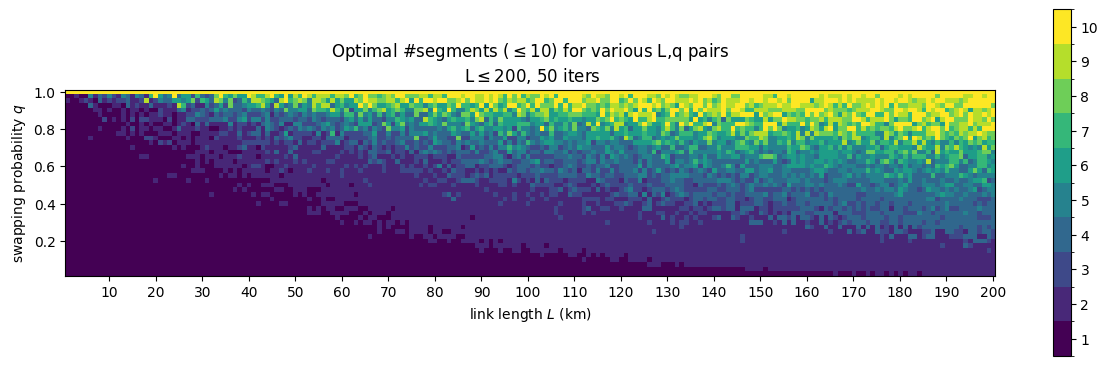

In [20]:
# Extract unique x and y values
x_values = sorted(set(kay[1] for kay in heatmap_dict_Lq_min_reps.keys()))  
y_values = sorted(set(kay[0] for kay in heatmap_dict_Lq_min_reps.keys()))  

heatmap_data = np.zeros((len(x_values), len(y_values)))  # Adjust shape based on swapped axes

# Fill the grid with values from the dictionary
for (y,x), value in heatmap_dict_Lq_min_reps.items():
    x_index = x_values.index(x)
    y_index = y_values.index(y)
    heatmap_data[x_index, y_index] = value

plt.figure(figsize=(15,15))

# Create the heatmap with a discrete color map
bounds = np.arange(1, 12)  # Discrete boundaries from 1 to 11 to include midpoints
cmap = plt.get_cmap('viridis', len(bounds) - 1)  # Use a colormap with discrete intervals
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.imshow(heatmap_data, origin='lower', cmap=cmap, norm=norm)

# Set custom ticks and labels for the axes
plt.xticks(range(9, len(y_values), 10), range(10, len(y_values)+1, 10))
plt.yticks(range(7, 40, 8), [round(r, 1) for r in np.arange(0.2, 1.2, 0.2)])

plt.xlabel('link length $L$ (km)') 
plt.ylabel('swapping probability $q$') 
plt.title('Optimal #segments ($\leq10$) for various L,q pairs \n L$\leq200$, 50 iters')

# Show the discrete colorbar
cbar = plt.colorbar(shrink=0.3)

# Calculate tick positions centered between boundaries
tick_positions = (bounds[:-1] + bounds[1:]) / 2
cbar.set_ticks(tick_positions)  # Set centered ticks
cbar.set_ticklabels(np.arange(1, 11))  # Set labels from 1 to 10

plt.show()

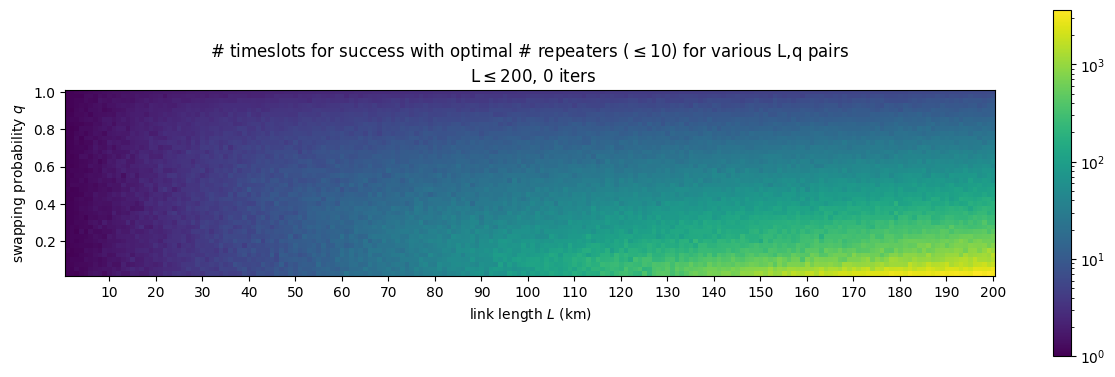

In [21]:
# Extract unique x and y values
x_values = sorted(set(kay[1] for kay in heatmap_dict_Lq_min_iters.keys()))  
y_values = sorted(set(kay[0] for kay in heatmap_dict_Lq_min_iters.keys()))  

heatmap_data = np.zeros((len(x_values), len(y_values)))  # Adjust shape based on swapped axes

# Fill the grid with values from the dictionary
for (y,x), value in heatmap_dict_Lq_min_iters.items():
    x_index = x_values.index(x)
    y_index = y_values.index(y)
    heatmap_data[x_index, y_index] = value

plt.figure(figsize=(15,15))

# Apply logarithmic normalization
cmap = plt.get_cmap('viridis')
norm = mcolors.LogNorm(vmin=1, vmax=heatmap_data.max())

# Create the heatmap using the logarithmic normalization
plt.imshow(heatmap_data, origin='lower', cmap=cmap, norm=norm)

# Set custom ticks and labels for the axes
plt.xticks(range(9, len(y_values), 10), range(10, len(y_values)+1, 10))
plt.yticks(range(7, 40, 8), [round(r, 1) for r in np.arange(0.2, 1.2, 0.2)])

plt.xlabel('link length $L$ (km)') 
plt.ylabel('swapping probability $q$') 
plt.title('# timeslots for success with optimal # repeaters ($\leq10$) for various L,q pairs \n L$\leq200$, 0 iters')

# Show the colorbar with logarithmic scale
cbar = plt.colorbar(shrink=0.3, norm=norm)

plt.show()

### L<1000, per 10km

In [22]:
LqN1000_fp = r"LqN\LqN1000.txt"
heatmap_dict_big = {}

with open(LqN1000_fp,'r') as hmb:
    hmb_txt_data = hmb.read()

    hmb_txt_data = hmb_txt_data.split('\n')

    for line in hmb_txt_data[:-1]:
        key_part, value_part = line.split(": ")
        key = eval(key_part.strip())
        value = eval(value_part.strip())
        heatmap_dict_big[key] = value

In [23]:
# manual removal
for kkk in heatmap_dict_big.copy():
    if kkk[0]>=800 and kkk[1]==0.05:
        #del heatmap_dict_big[kkk]
        continue

In [94]:
for L__ in range(10,1000+10,10):

    for q__ in range(5,100+5,5):
        q__ = q__/100

        for N__ in range(1,30+1):
            # at longer lengths, direct link is never optimal
            if L__>200 and N__ == 1:
                continue
            elif q__<=0.6 and N__>20:
                continue
            elif q__<=0.4 and N__>15:
                continue
            elif q__<=0.2 and N__>10:
                continue
            elif q__==0.05:
                if (L__<=650 and N__>6) or N__>8 or (L__>500 and N__<4):
                    continue
                if (L__>=800 and (N__>6 or N__<4)):
                    continue

            heatmap_dict_big_keys = heatmap_dict_big.keys()
            
            # check if prev asc.
            # if previous 3 values increasing, terminate
            if (L__,q__,N__-3) in heatmap_dict_big_keys:
                prev3_l = [np.mean(heatmap_dict_big[(L__,q__,enn)]) for enn in (N__-3,N__-2,N__-1)]
                if sorted(prev3_l) == prev3_l and len(set(prev3_l))==3:
                    break

            if (L__,q__,N__) not in heatmap_dict_big_keys:

                print(f'generating on ({L__},{q__},{N__})')

                if q__ == 1:
                    heatmap_dict_big[(L__,q__,N__)] = [exp_subl(L__,N__)]
                elif q__ == 0.1 and L__ >= 600:
                    heatmap_dict_big[(L__,q__,N__)] = iter_SaE_mp(i=30,N=N__,L=L__,q=q__,max_iter=5000000)
                elif q__ == 0.05:
                    heatmap_dict_big[(L__,q__,N__)] = iter_SaE_mp(i=30,N=N__,L=L__,q=q__,max_iter=100000000)
                else:
                    heatmap_dict_big[(L__,q__,N__)] = iter_SaE_mp(i=30,N=N__,L=L__,q=q__,max_iter=1000000)
                    
                
                #clear_output(wait=True)
                print(f'({L__},{q__},{N__}) complete')

                #if keyboard.is_pressed('z'): # hold s to end at next iter
                #    raise KeyboardInterrupt
             
            # if timeslots <1k, 100 iter
            if np.mean(heatmap_dict_big[(L__,q__,N__)]) <= 1000 and len(heatmap_dict_big[(L__,q__,N__)])==30 and q__!=1:
                temp_l = iter_SaE_mp(i=70,N=N__,L=L__,q=q__,max_iter=100000)
                heatmap_dict_big[(L__,q__,N__)] = heatmap_dict_big[(L__,q__,N__)].copy() + temp_l
                #clear_output(wait=True)
                print(f'({L__},{q__},{N__}) expanded')

generating on (980,0.05,4)


100%|██████████| 30/30 [1:02:23<00:00, 124.80s/it] 


(980,0.05,4) complete
generating on (980,0.05,5)


100%|██████████| 30/30 [1:06:16<00:00, 132.54s/it] 


(980,0.05,5) complete
generating on (980,0.05,6)


100%|██████████| 30/30 [1:25:22<00:00, 170.76s/it] 


(980,0.05,6) complete
generating on (990,0.05,4)


100%|██████████| 30/30 [58:23<00:00, 116.77s/it]   


(990,0.05,4) complete
generating on (990,0.05,5)


100%|██████████| 30/30 [1:12:50<00:00, 145.68s/it] 


(990,0.05,5) complete
generating on (990,0.05,6)


100%|██████████| 30/30 [1:27:52<00:00, 175.75s/it] 


(990,0.05,6) complete
generating on (1000,0.05,4)


100%|██████████| 30/30 [1:05:54<00:00, 131.82s/it] 


(1000,0.05,4) complete
generating on (1000,0.05,5)


100%|██████████| 30/30 [1:12:04<00:00, 144.16s/it] 


(1000,0.05,5) complete
generating on (1000,0.05,6)


100%|██████████| 30/30 [1:11:42<00:00, 143.40s/it] 

(1000,0.05,6) complete


In [95]:
for kkk in heatmap_dict_big:
    if isinstance(kkk[1], np.float64) or isinstance(heatmap_dict_big[kkk][0], np.int64):
        try:
            heatmap_dict_big[(kkk[0],kkk[1].item(),kkk[2])] = [x.item() for x in heatmap_dict_big[kkk]]
            print(kkk)
            print(heatmap_dict_big[kkk])
        except AttributeError:
            pass

In [96]:
heatmap_dict_big = {key:heatmap_dict_big[key] for key in sorted(heatmap_dict_big.keys())}

filepath_LqN_big_iter = f'LqN\\LqN1000.txt'
with open(filepath_LqN_big_iter, 'w') as file:
        for key_ in heatmap_dict_big:
            if isinstance(key_[1], np.float64):
                key_ = (key_[0],key_[1].item(),key_[2])
                
            if len(heatmap_dict_big[key_])>1 and ( isinstance(heatmap_dict_big[key_][0], np.int64) or isinstance(heatmap_dict_big[key_][0], np.int32) ):
                list_ = [x.item() for x in heatmap_dict_big[key_]]
            else:
                list_ = heatmap_dict_big[key_]
            file.write(f'{key_}: {list_}'+'\n')

In [97]:
filepath_LqN_big_iter = f'LqN\\LqN1000_lowq.txt'
with open(filepath_LqN_big_iter, 'w') as file:
        for key_ in heatmap_dict_big:
            if key_[1] <= 0.1 and key_[0]>200:
                if isinstance(key_[1], np.float64):
                    key_ = (key_[0],key_[1].item(),key_[2])
                file.write(f'{key_}: {heatmap_dict_big[key_]}'+'\n')

In [98]:
heatmap_dict_big_Lq = {}

for LqN in heatmap_dict_big:
    L__ = LqN[0]
    q__ = LqN[1]
    N__ = LqN[2]
    if (L__,q__) not in heatmap_dict_big_Lq:
        heatmap_dict_big_Lq[(L__,q__)] = {}
    heatmap_dict_big_Lq[(L__,q__)][N__] = np.mean(heatmap_dict_big[LqN])

heatmap_dict_big_Lq_min_reps = {}
for key_ in heatmap_dict_big_Lq:
    heatmap_dict_big_Lq_min_reps[key_] = min(heatmap_dict_big_Lq[key_], key=heatmap_dict_big_Lq[key_].get)

heatmap_dict_big_Lq_min_iters = {}
for key_ in heatmap_dict_big_Lq:
    heatmap_dict_big_Lq_min_iters[key_] = min(heatmap_dict_big_Lq[key_].values())

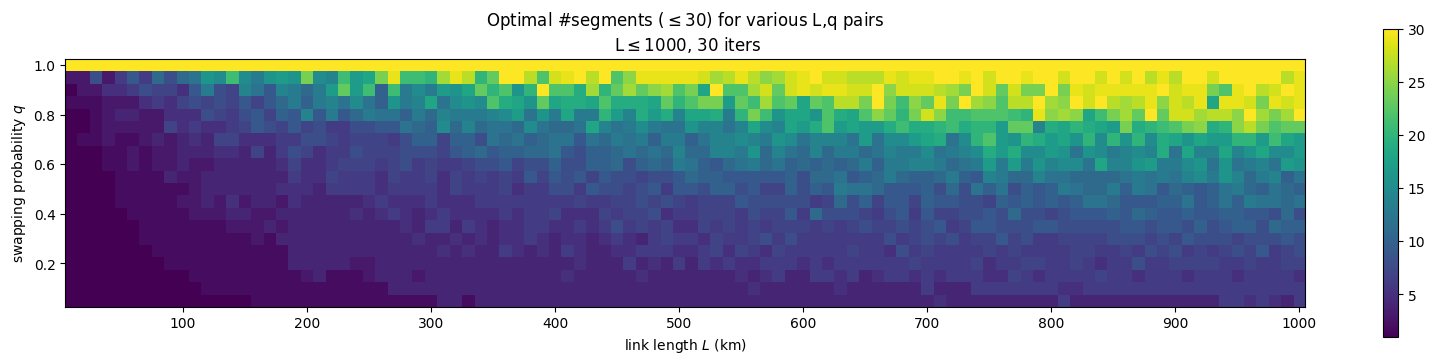

In [102]:
# Extract unique x and y values
x_values = sorted(set(kay[1] for kay in heatmap_dict_big_Lq_min_reps.keys()))  
y_values = sorted(set(kay[0] for kay in heatmap_dict_big_Lq_min_reps.keys()))  

heatmap_data = np.zeros((len(x_values), len(y_values)))

# Fill the grid with values from the dictionary
for (y,x), value in heatmap_dict_big_Lq_min_reps.items():
    x_index = x_values.index(x)  
    y_index = y_values.index(y)  
    heatmap_data[x_index, y_index] = value  # Adjusted to match swapped axes

plt.figure(figsize=(20,20))

cmap = plt.get_cmap('viridis')

plt.imshow(heatmap_data, origin='lower',cmap=cmap)#, norm=norm)

# Set custom ticks and labels for the axes
plt.xticks(range(10-1, len(y_values), 10), range(100, len(y_values)*10+1, 100))
plt.yticks(range(3, 20, 4), [round(r, 1) for r in np.arange(0.2, 1.2, 0.2)])

plt.xlabel('link length $L$ (km)') 
plt.ylabel('swapping probability $q$') 
plt.title('Optimal #segments ($\leq30$) for various L,q pairs \n L$\leq1000$, 30 iters')

# Show the discrete colorbar
cbar = plt.colorbar(shrink=0.2)

num_disp = False
if num_disp:
    for (j,i),label in np.ndenumerate(heatmap_data):
        plt.text(i,j,round(label),ha='center',va='center',fontsize=5)

plt.show()

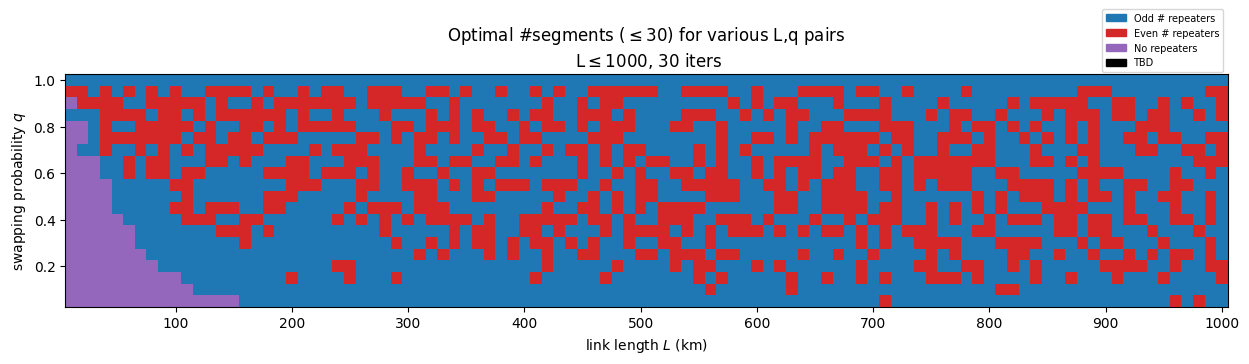

In [100]:
# odd/even segm.

x_values = sorted(set(kay[1] for kay in heatmap_dict_big_Lq_min_reps.keys()))  
y_values = sorted(set(kay[0] for kay in heatmap_dict_big_Lq_min_reps.keys()))  

heatmap_data = np.zeros((len(x_values), len(y_values)))

# Fill the grid with values from the dictionary
for (y,x), value in heatmap_dict_big_Lq_min_reps.items():
    x_index = x_values.index(x)  
    y_index = y_values.index(y)  
    heatmap_data[x_index, y_index] = value  # Adjusted to match swapped axes
    
plt.figure(figsize=(15, 15))

# Define a custom colormap for 1, even, odd (not 1) numbers, and 0
colors = ['tab:blue', 'tab:red', 'tab:purple', 'black']  # Order: even, odd (not 1), 1, 0
cmap = mcolors.ListedColormap(colors)

# Create a normalization that maps values to the custom colormap
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]  # Mapping 0 to black, even to blue, odd to red, and 1 to purple
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Map heatmap data to the color scheme
color_mapped_data = np.full_like(heatmap_data, 1)  # Default to odd (not 1)
color_mapped_data[heatmap_data == 1] = 2  # Set 1 to purple
color_mapped_data[heatmap_data % 2 == 0] = 0  # Set even to blue (except for 0)
color_mapped_data[heatmap_data == 0] = 3  # Set 0 to black

# Create the heatmap using the custom colormap
plt.imshow(color_mapped_data, origin='lower', cmap=cmap, norm=norm)

# Set custom ticks and labels for the axes
plt.xticks(range(10-1, len(y_values), 10), range(100, len(y_values)*10+1, 100))
plt.yticks(range(3, 20, 4), [round(r, 1) for r in np.arange(0.2, 1.2, 0.2)])

plt.xlabel('link length $L$ (km)')
plt.ylabel('swapping probability $q$')
plt.title('Optimal #segments ($\leq30$) for various L,q pairs \n L$\leq1000$, 30 iters')

# Display numbers on the heatmap
num_disp = False
if num_disp:
    for (j, i), label in np.ndenumerate(heatmap_data):
        plt.text(i, j, round(label), ha='center', va='center', fontsize=5)

# Create custom legend
even_patch = mpatches.Patch(color='tab:blue', label='Odd # repeaters')
odd_patch = mpatches.Patch(color='tab:red', label='Even # repeaters')
one_patch = mpatches.Patch(color='tab:purple', label='No repeaters')
zero_patch = mpatches.Patch(color='black', label='TBD')

plt.legend(handles=[even_patch, odd_patch, one_patch, zero_patch], loc='upper right', fontsize=7, bbox_to_anchor=(1, 1.3))

plt.show()

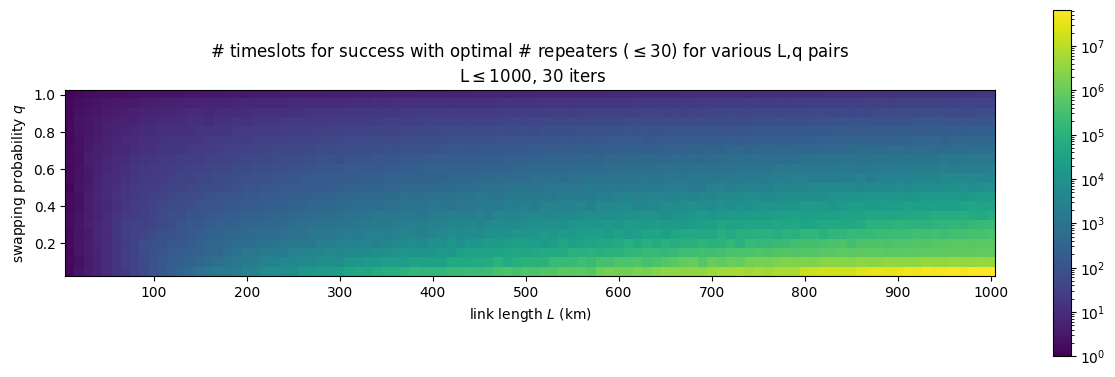

In [101]:
# Extract unique x and y values
x_values = sorted(set(kay[1] for kay in heatmap_dict_big_Lq_min_iters.keys()))  
y_values = sorted(set(kay[0] for kay in heatmap_dict_big_Lq_min_iters.keys()))  

heatmap_data = np.zeros((len(x_values), len(y_values)))

# Fill the grid with values from the dictionary
for (y,x), value in heatmap_dict_big_Lq_min_iters.items():
    x_index = x_values.index(x)  
    y_index = y_values.index(y)  
    heatmap_data[x_index, y_index] = value  # Adjusted to match swapped axes

plt.figure(figsize=(15, 15))

# Apply logarithmic normalization
cmap = plt.get_cmap('viridis')
norm = mcolors.LogNorm(vmin=1, vmax=heatmap_data.max())

# Create the heatmap using the logarithmic normalization
plt.imshow(heatmap_data, origin='lower', cmap=cmap, norm=norm)

# Set custom ticks and labels for the axes
plt.xticks(range(10-1, len(y_values), 10), range(100, len(y_values)*10+1, 100))
plt.yticks(range(3, 20, 4), [round(r, 1) for r in np.arange(0.2, 1.2, 0.2)])

plt.xlabel('link length $L$ (km)') 
plt.ylabel('swapping probability $q$') 
plt.title('# timeslots for success with optimal # repeaters ($\leq30$) for various L,q pairs \n L$\leq1000$, 30 iters')

# Show the colorbar with logarithmic scale
cbar = plt.colorbar(shrink=0.3, norm=norm)

plt.show()